# Ecological Analysis of Accelerator-VC Bipartite Networks

Analysis of the French accelerator-VC network using ecological metrics inspired by Carniel's work on complex networks in entrepreneurial ecosystems.

**Focus**: Nestedness, Modularity, Connectance, and network resilience patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from utils.data_cleaning import *
from utils.data_extraction import *
from utils.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

Load and clean French startup ecosystem data using enhanced techniques.

In [2]:
raw_data = load_data('data/us')
# Load data
companies = raw_data['companies']
investors = raw_data['investors']
investments = raw_data['investments']
funding_rounds = raw_data['funding_rounds']

print(f"Companies: {len(companies):,}")
print(f"Investors: {len(investors):,}")
print(f"Investments: {len(investments):,}")
print(f"Funding rounds: {len(funding_rounds):,}")

Companies: 820,313
Investors: 38,843
Investments: 424,188
Funding rounds: 268,283


In [3]:
# Data cleaning based on Dalle et al. + Carniel insights
cleaned_data = create_final_sample(raw_data, funding_threshold=150000)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")


1. Cleaning companies data
Initial companies count: 820313
Removed 140948 companies founded after 2017
Removed 82217 companies with exit status
Final companies count after cleaning: 597148
Total removed: 223165

2. Cleaning funding data
Initial investments count: 424188
Removed 34038 investments with invalid funding amounts
Final investments count after cleaning: 390150
Total removed: 34038

3. Apply funding threshold ($150,000 as per paper)
Applying funding threshold of $150,000
Companies meeting funding threshold: 59515
Filtered companies: 23320
Filtered investments: 381360

4. Excluding accelerator-only companies (prevent endogeneity bias)
Companies with accelerator-only funding: 2445
Companies after excluding accelerator-only: 22527
Investments after excluding accelerator-only: 378373

FINAL SAMPLE:
Companies: 22527
Investments: 147832
Unique investors: 22101
After cleaning:
Companies: 22,527
Investors: 38,843


## Accelerator-VC Network Construction

Build bipartite network following the methodology from 07_19.ipynb but with ecological focus.

In [4]:
accelerated_investments = extract_accelerator_investments(cleaned_data['investments'])

print("\nSample of accelerator investments:")
if 'company_name' in accelerated_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(accelerated_investments[display_cols].head())
else:
    print(accelerated_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
print("\nAccelerator-VC pairs:")
accelerator_vc_pairs = create_investment_pairs(accelerated_investments, vc_investments, 'acc', 'vc')
print(accelerator_vc_pairs[['org_uuid', 'investor_name_acc', 'investor_name_vc']].head())

Found 7130 accelerator investments
Unique companies in accelerators: 4383

Sample of accelerator investments:
         company_name       investor_name investor_types  total_funding_usd
846        RescueTime        Y Combinator    accelerator           920000.0
1389           Scribd        Y Combinator    accelerator        106750000.0
1671       Snap Shots             Idealab      incubator         10000000.0
3211  Ambient Devices  Rose Tech Ventures      incubator          8600000.0
3218   Critical Media  Rose Tech Ventures      incubator          6200000.0
Found 103585 VC investments
Unique companies with VC funding: 16899

Sample of VC investments:
   company_name               investor_name            investor_types  \
7        Scribd                    Redpoint           venture capital   
14      MeetMoi       Acadia Woods Partners           venture capital   
19        OpenX         First Round Capital           venture capital   
20        OpenX  Oreilly AlphaTech Ventures  mi

## Ecological Network Analysis

Comprehensive analysis using ecological metrics inspired by Carniel's framework.

In [5]:
acc_vc_edges = extract_bipartite_edges_from_pairs(
    accelerator_vc_pairs, 
    'investor_name_acc', 
    'investor_name_vc',
    'total_funding_usd'
)

# Bbipartite analysis with ecological metrics
network_analysis = analyze_bipartite_structure_robust(
    acc_vc_edges,
    'investor_name_acc',
    'investor_name_vc',
    'total_funding_usd',
    'Accelerators',
    'VCs',
    handle_overlap='suffix'
)

# Extract key metrics
basic_metrics = network_analysis['basic_metrics']
ecological_summary = network_analysis['ecological_summary']

print("=== Network Structure ===")
print(f"Nodes: {basic_metrics['num_nodes']} ({basic_metrics['set_0_size']} accelerators + {basic_metrics['set_1_size']} VCs)")
print(f"Edges: {basic_metrics['num_edges']}")
print(f"Density: {basic_metrics['density']:.3f}")
print(f"Components: {basic_metrics['num_components']}")

print("\n=== Ecological Metrics ===")
print(f"Connectance: {ecological_summary['connectance']:.3f}") # Or density
print(f"Nestedness (NODF): {ecological_summary['nestedness_nodf']:.1f}")
print(f"Modularity: {ecological_summary['modularity']:.3f}")

# @todo review cross assortativity, maybe doenst make sense
# print(f"Cross-assortativity: {ecological_summary['cross_assortativity']:.3f}")

Overlapping nodes: ['Evolution Ventures', 'Adjacent', 'Owl Ventures', 'Jumpstart Ventures', 'Signal Ventures']...
Added suffixes to create pseudo-bipartite structure
=== Network Structure ===
Nodes: 6936 (889 accelerators + 6047 VCs)
Edges: 23295
Density: 0.004
Components: 35

=== Ecological Metrics ===
Connectance: 0.004
Nestedness (NODF): 6.6
Modularity: 0.246


In [6]:
# Ecological interpretation
ecology_summary = summarize_bipartite_ecology(network_analysis)

print("=== Ecological Interpretation ===")
print(f"Network Type: {ecology_summary['network_type']}")
print(f"Connectance: {ecology_summary['connectance_interpretation']}")
print(f"Nestedness: {ecology_summary['nestedness_interpretation']}")
print(f"Modularity: {ecology_summary['modularity_interpretation']}")
print(f"Resilience: {ecology_summary['resilience_prediction']}")

=== Ecological Interpretation ===
Network Type: Mixed architecture
Connectance: Low connectance - sparse network
Nestedness: Low nestedness - modular structure
Modularity: Medium modularity - moderate communities
Resilience: Variable resilience patterns


## Network Visualization

Visual analysis of the bipartite structure and nestedness pattern.

<Figure size 1000x800 with 0 Axes>

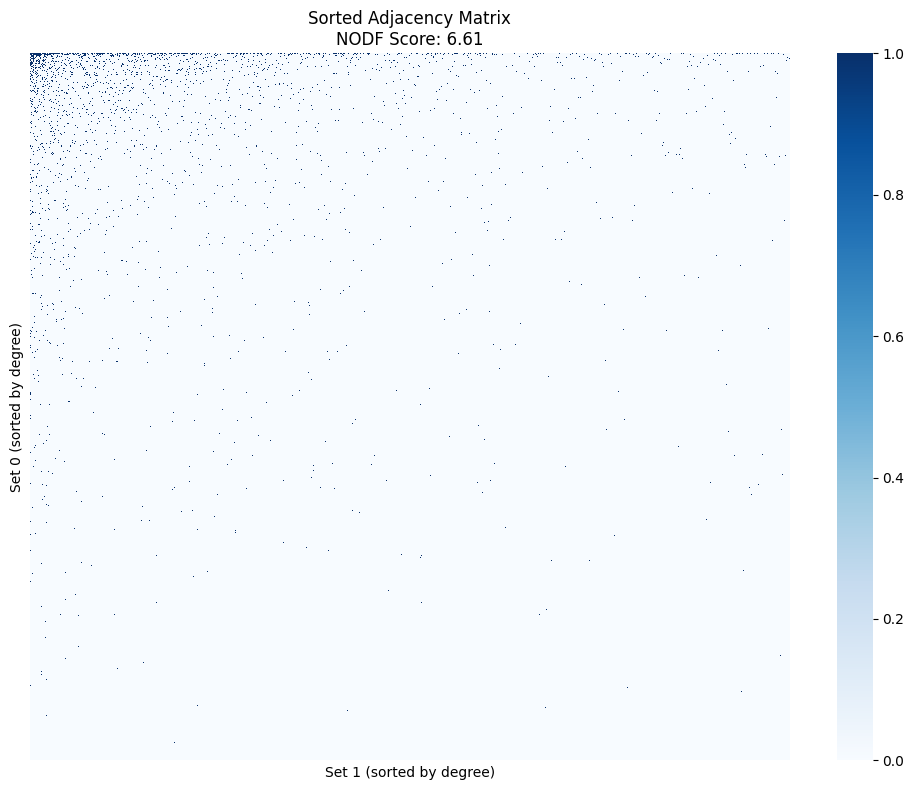

In [7]:
# Nestedness matrix visualization
plt.figure(figsize=(10, 8))
visualize_nestedness_matrix(network_analysis['nestedness'])

# @note the matrix is sparse, if we remove less connected nodes maybe nestedness will be biger
# or simply cluster it before and measure in the clusters

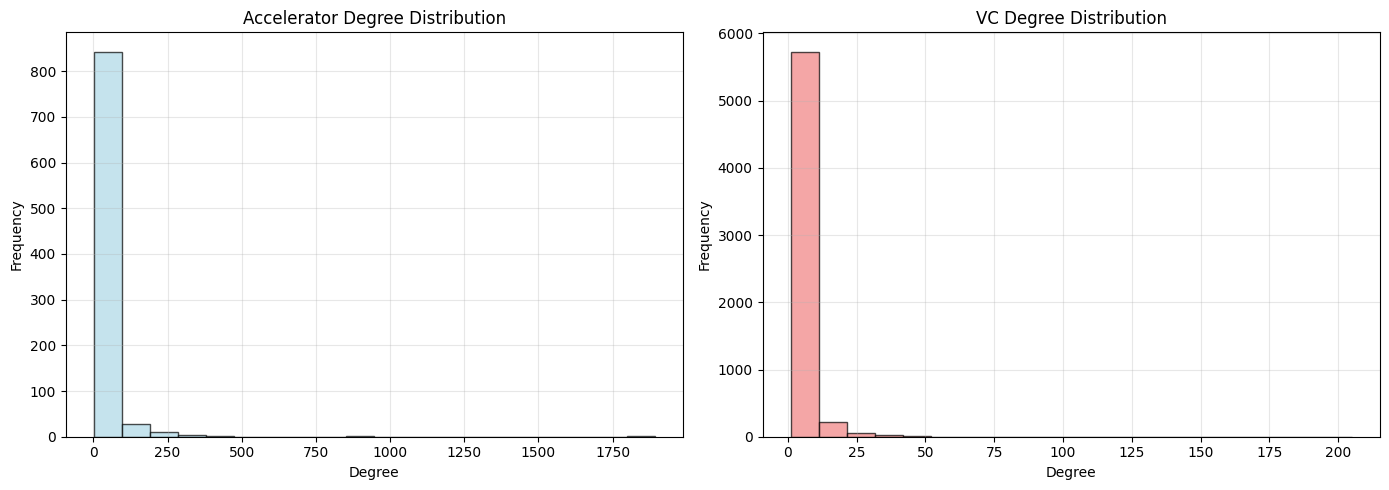

Accelerator degrees: mean=26.2, max=1893
VC degrees: mean=3.9, max=205


In [8]:
# Degree distribution analysis
G = network_analysis['graph']
bip_info = is_bipartite_graph(G)
set_0 = bip_info['set_0']  # accelerators
set_1 = bip_info['set_1']  # VCs

degrees_acc = [G.degree(n) for n in set_0]
degrees_vc = [G.degree(n) for n in set_1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accelerator degrees
ax1.hist(degrees_acc, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Accelerator Degree Distribution')
ax1.grid(True, alpha=0.3)

# VC degrees
ax2.hist(degrees_vc, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Frequency')
ax2.set_title('VC Degree Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Accelerator degrees: mean={np.mean(degrees_acc):.1f}, max={max(degrees_acc)}")
print(f"VC degrees: mean={np.mean(degrees_vc):.1f}, max={max(degrees_vc)}")

## Projection Networks Analysis

Analysis of accelerator and VC projection networks.

In [9]:
# Projection analysis -> transforms bipartite in unipartite
# we connect nodes that share neighbors -> weak connections
projections = network_analysis['projections']
acc_proj = projections['projection_0']
vc_proj = projections['projection_1']

print("=== Projection Networks ===")
print(f"Accelerator projection: {acc_proj.number_of_nodes()} nodes, {acc_proj.number_of_edges()} edges")
print(f"VC projection: {vc_proj.number_of_nodes()} nodes, {vc_proj.number_of_edges()} edges")

# Projection densities
acc_density = nx.density(acc_proj)
vc_density = nx.density(vc_proj)

print(f"Accelerator projection density: {acc_density:.3f}")
print(f"VC projection density: {vc_density:.3f}")

=== Projection Networks ===
Accelerator projection: 889 nodes, 64370 edges
VC projection: 6047 nodes, 2775584 edges
Accelerator projection density: 0.163
VC projection density: 0.152


## Key Actors Analysis

Identification of central accelerators and VCs in the network.

In [10]:
# Top accelerators and VCs by degree
acc_degrees = [(n, G.degree(n)) for n in set_0]
vc_degrees = [(n, G.degree(n)) for n in set_1]

acc_degrees.sort(key=lambda x: x[1], reverse=True)
vc_degrees.sort(key=lambda x: x[1], reverse=True)

print("=== Top 10 Accelerators by Degree ===")
for name, degree in acc_degrees[:10]:
    print(f"{name}: {degree} connections")

print("\n=== Top 10 VCs by Degree ===")
for name, degree in vc_degrees[:10]:
    print(f"{name}: {degree} connections")

=== Top 10 Accelerators by Degree ===
Y Combinator_Accelerators: 1893 connections
MassChallenge_Accelerators: 914 connections
Thrive Capital_Accelerators: 429 connections
Alchemist Accelerator_Accelerators: 426 connections
IQT_Accelerators: 366 connections
MedTech Innovator_Accelerators: 322 connections
NTT DOCOMO Ventures_Accelerators: 297 connections
Google for Startups_Accelerators: 283 connections
SkyDeck Berkeley_Accelerators: 265 connections
TechNexus Venture Collaborative_Accelerators: 259 connections

=== Top 10 VCs by Degree ===
Techstars_VCs: 205 connections
Right Side Capital Management_VCs: 117 connections
500 Global_VCs: 117 connections
Alumni Ventures_VCs: 109 connections
Plug and Play_VCs: 101 connections
Bossa Invest_VCs: 93 connections
Gaingels_VCs: 85 connections
SOSV_VCs: 73 connections
SV Angel_VCs: 64 connections
Tiger Global Management_VCs: 55 connections


## Network Report

Comprehensive summary for comparative analysis with other ecosystems.

In [13]:
# Generate comprehensive report
network_report = {
    'dataset': 'US Startup Ecosystem',
    'analysis_date': '2025-07-21',
    'network_size': {
        'total_nodes': basic_metrics['num_nodes'],
        'accelerators': basic_metrics['set_0_size'],
        'vcs': basic_metrics['set_1_size'],
        'total_edges': basic_metrics['num_edges']
    },
    'structural_metrics': {
        'density': basic_metrics['density'],
        'connectance': ecological_summary['connectance'],
        'components': basic_metrics['num_components'],
        'largest_component_size': basic_metrics['largest_component_size']
    },
    'ecological_metrics': {
        'nestedness_nodf': ecological_summary['nestedness_nodf'],
        'modularity': ecological_summary['modularity'],
        'cross_assortativity': ecological_summary['cross_assortativity']
    },
    'degree_statistics': {
        'acc_mean_degree': np.mean(degrees_acc),
        'acc_max_degree': max(degrees_acc),
        'vc_mean_degree': np.mean(degrees_vc),
        'vc_max_degree': max(degrees_vc)
    },
    'ecological_interpretation': ecology_summary,
    'top_actors': {
        'top_accelerators': [{'name': name, 'degree': degree} for name, degree in acc_degrees[:5]],
        'top_vcs': [{'name': name, 'degree': degree} for name, degree in vc_degrees[:5]]
    }
}

print(f"Analysis Date: {network_report['analysis_date']}")
print(f"Dataset: {network_report['dataset']}")

print("\n--- Network Structure ---")
ns = network_report['network_size']
print(f"Total nodes: {ns['total_nodes']} ({ns['accelerators']} accelerators + {ns['vcs']} VCs)")
print(f"Total edges: {ns['total_edges']}")

print("\n--- Key Metrics ---")
sm = network_report['structural_metrics']
em = network_report['ecological_metrics']
print(f"Density: {sm['density']:.3f}")
print(f"Connectance: {sm['connectance']:.3f}")
print(f"Nestedness (NODF): {em['nestedness_nodf']:.1f}")
print(f"Modularity: {em['modularity']:.3f}")
print(f"Cross-assortativity: {em['cross_assortativity']:.3f}")

print("\n--- Ecological Classification ---")
ei = network_report['ecological_interpretation']
print(f"Network Type: {ei['network_type']}")
print(f"Resilience Pattern: {ei['resilience_prediction']}")

Analysis Date: 2025-07-21
Dataset: US Startup Ecosystem

--- Network Structure ---
Total nodes: 6936 (889 accelerators + 6047 VCs)
Total edges: 23295

--- Key Metrics ---
Density: 0.004
Connectance: 0.004
Nestedness (NODF): 6.6
Modularity: 0.246
Cross-assortativity: -0.108

--- Ecological Classification ---
Network Type: Mixed architecture
Resilience Pattern: Variable resilience patterns


In [14]:
# Save report for future comparisons
import json
with open('network_report_2025.json', 'w') as f:
    json.dump(network_report, f, indent=2, default=str)

print("Network report saved to 'network_report_2025.json'")
print("Ready for comparative analysis with other datasets.")

Network report saved to 'network_report_2025.json'
Ready for comparative analysis with other datasets.
